## Predicting Customer Subscription Following Phone Contact
The following code cells use different model architectures to try to predict whether a customer will subscribe to a term deposit following phone marketing contact. The dataset is the Bank Marketing dataset downloaded from the UCI ML Repository: https://archive.ics.uci.edu/dataset/222/bank+marketing 

Data was preprocessed and normalized in the data_processing.ipynb notebook. 

The training dataset contains 35,938 samples with the following features:
* customer age
* customer job category
* customer marital status
* customer education level
* binary indicator of whether customer has credit in default
* customer's average yearly balance
* binary indicator of whether customer has housing loan
* binary indicator of whether customer has personal loan
* contact communication type (telephone vs cellular)
* day of month when customer was last contacted
* month when customer was last contacted
* number of contacts performed for this customer for this campaign
* number of days passed since customer was last contacted for another campaign
* number of contacts performed for this customer for previous campaigns
* outcome of previous marketing campaigns for this customer

### Loading Data
Most architectures will use the encoded and normalized data saved in X_train_normed.csv. The unnormalized data is being loaded for use with XGBoost and similar tree-based architectures.

In [49]:
#Load libraries
import xgboost as xgb
from catboost import CatBoostClassifier
import torch
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics.functional import binary_f1_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from scipy.stats import uniform

from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC

In [50]:
#Load datasets
X_train_normed = pd.read_csv("X_train_normed.csv")
X_train_nonorm = pd.read_csv("X_train_nonorm.csv")
X_val_normed = pd.read_csv("X_val_normed.csv")
X_val_nonorm = pd.read_csv("X_val_nonorm.csv")
X_test_normed = pd.read_csv("X_test_normed.csv")
X_test_nonorm = pd.read_csv("X_test_nonorm.csv")
y_train = pd.read_csv("y_train.csv")
y_val = pd.read_csv("y_val.csv")
y_test = pd.read_csv("y_test.csv")

X_train_nonorm_smote = pd.read_csv("X_train_nonorm_smoted.csv")
X_train_normed_smote = pd.read_csv("X_train_normed_smoted.csv")
y_train_smote = pd.read_csv("y_train_smoted.csv")

#set seed
np.random.seed(42)

In [51]:
#change 'object' dtype to 'categorical' dtype for nonorm data
catcols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for col in catcols:
    X_train_nonorm[col] = X_train_nonorm[col].astype('category')
    X_val_nonorm[col] = X_val_nonorm[col].astype('category')
    X_test_nonorm[col] = X_test_nonorm[col].astype('category')
    X_train_nonorm_smote[col] = X_train_nonorm_smote[col].astype('category')

In [52]:
#Remove some negative examples from smote-enhanced data to create a dataset with equal representation of classes
X_train_normed_smote_reduced = []
y_train_smote_reduced = []
npos = sum(y_train_smote['label'])
numneg = 0
for i in range(len(y_train_smote)):
    if y_train_smote['label'].iloc[i] == 1:
        X_train_normed_smote_reduced.append(X_train_normed_smote.loc[i])
        y_train_smote_reduced.append(y_train_smote.loc[i])
    else: #can just take the top npos negative samples since the df is already shuffled
        if numneg < npos:
            X_train_normed_smote_reduced.append(X_train_normed_smote.loc[i])
            y_train_smote_reduced.append(y_train_smote.loc[i])
            numneg += 1

y_train_smote_reduced = pd.DataFrame(y_train_smote_reduced)
X_train_normed_smote_reduced = pd.DataFrame(X_train_normed_smote_reduced)

In [53]:
#Look at proportion of positive samples in each dataset

def percent_pos(labels):
    return(sum(labels)/len(labels))

print("Fraction of positive examples in each dataset:")
print("y_train: %f"%percent_pos(y_train['label']))
print("y_train with smote: %f"%percent_pos(y_train_smote['label']))
print("y_train with smote and majority undersampling: %f"%percent_pos(y_train_smote_reduced['label']))

Fraction of positive examples in each dataset:
y_train: 0.117757
y_train with smote: 0.333325
y_train with smote and majority undersampling: 0.500000


The initial dataset contains only 12% positive examples. The dataset with synthetic minority samples contains 33% positive examples, while an additional variation on that dataset removes majority samples so that the data contains 50% positive examples. When training on the unbalanced datasets, we should use class weighting attributes of the models to place more emphasis on the positive samples. When assessing model accuracy, we should note that a model that always predicts 'False' (i.e. the customer will not subscribe) will be accurate 88% of the time on the base dataset, and therefore we need to look at other measures such as precision, recall, and F1 score.

We are trying to predict whether a customer will subscribe to a term deposit following phone marketing contact. If this model is intended to be used for customer segmentation, e.g. targeting phone marketing campaigns towards the customers who are most likely to respond favorably, then we are willing to risk some false positives (people who will not subscribe despite being called) in order to avoid false negatives (people who would have subscribed if we had called them, but we didn't contact them). In such cases where the cost of a false negative is higher than the cost of a false positive, a good performance metric is recall.

In [54]:
#Create function to print summary of classifier performance
def predtest(y_pred, y_true):
    acc = accuracy_score(y_pred, y_true)
    f1 = f1_score(y_pred, y_true)
    prec = precision_score(y_pred, y_true)
    rec = recall_score(y_pred, y_true)
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    print("Precision: {}".format(prec))
    print("Recall: {}".format(rec))
    return([acc, f1, prec, rec])

#Initalize list for storing performance metrics
metrics = []

### Logistic Regression
First we will try the most straightforward ML architecture, good old logistic regression.

In [55]:
#l2 regularization
lr1 = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42) #weight minority samples more heavily
lr1.fit(X_train_normed, y_train['label'])
lr_preds1 = lr1.predict(X_val_normed)
lr1_metrics = predtest(lr_preds1, y_val['label'])

Accuracy: 0.721875927574948
F1-Score: 0.32395382395382394
Precision: 0.5727040816326531
Recall: 0.22585513078470826


In [56]:
#Try different values for C parameter
Cvals = [5.0, 2.0, 1.0, 0.8, 0.6, 0.4]
for Cval in Cvals:
    lr1 = LogisticRegression(penalty='l2', class_weight='balanced', C=Cval, random_state=42)
    lr1.fit(X_train_normed, y_train['label'])
    preds1 = lr1.predict(X_val_normed)
    r = recall_score(preds1, y_val['label'])
    print("C={}, Recall: {}".format(Cval, r))

C=5.0, Recall: 0.22608257804632426
C=2.0, Recall: 0.22546552591847005
C=1.0, Recall: 0.22585513078470826
C=0.8, Recall: 0.22585513078470826
C=0.6, Recall: 0.22528850978424486
C=0.4, Recall: 0.2249498997995992


Varying C does not change our recall much. Let's look at using a different training dataset.

In [57]:
#Try dataset with synthetic positive examples
lr2 = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=500, random_state=42)
lr2.fit(X_train_normed_smote, y_train_smote['label'])
preds2 = lr2.predict(X_val_normed)
lr2_metrics = predtest(preds2, y_val['label'])

Accuracy: 0.8205699020480854
F1-Score: 0.34894991922455576
Precision: 0.413265306122449
Recall: 0.3019571295433364


In [58]:
#Try dataset with equal classes
lr3 = LogisticRegression(penalty='l2', max_iter=500, random_state=42)
lr3.fit(X_train_normed_smote_reduced, y_train_smote_reduced['label'])
preds3 = lr3.predict(X_val_normed)
lr3_metrics = predtest(preds3, y_val['label'])

Accuracy: 0.8211635500148412
F1-Score: 0.3518020441097364
Precision: 0.41709183673469385
Recall: 0.3041860465116279


The use of synthetic minority samples slightly improves recall (from 0.23 to 0.30). Removing majority class samples to balance the classes has little effect; the class_weight='balanced' parameter successfully draws attention to the minority samples in the unbalanced dataset. Let's try some different regularization techniques on the smote-enhanced data.

In [60]:
#l1 regularization
lr4 = LogisticRegression(penalty='l1', class_weight='balanced', solver='saga', max_iter=700, random_state=42)
lr4.fit(X_train_normed_smote, y_train_smote['label'])
preds4 = lr4.predict(X_val_normed)
lr4_metrics = predtest(preds4, y_val['label'])

Accuracy: 0.8219056099732859
F1-Score: 0.35064935064935066
Precision: 0.413265306122449
Recall: 0.30451127819548873


In [61]:
#elasticnet regularization
lr5 = LogisticRegression(penalty='elasticnet', class_weight='balanced', solver='saga', max_iter=700, l1_ratio=0.5, random_state=42)
lr5.fit(X_train_normed_smote, y_train_smote['label'])
preds5 = lr5.predict(X_val_normed)
lr5_metrics = predtest(preds5, y_val['label'])

Accuracy: 0.821460373998219
F1-Score: 0.3500810372771475
Precision: 0.413265306122449
Recall: 0.3036551077788191


Logistic regression is able to achieve recall values maxing out around 0.30. Let's try some other architectures and see if we can improve prediction performance.

In [62]:
#Append best-performing model metrics to metrics list
metrics.append(('lr4', lr4_metrics))

### KNN
Our data is likely too sparse for KNN to work well, but let's give it a try.

In [64]:
#initial dataset
knn1 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn1.fit(X_train_normed, y_train['label'])
knn1_preds = knn1.predict(X_val_normed)
knn1_metrics = predtest(knn1_preds, y_val['label'])

Accuracy: 0.8867616503413476
F1-Score: 0.2980680772769089
Precision: 0.2066326530612245
Recall: 0.5346534653465347


In [65]:
#smote dataset
knn2 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn2.fit(X_train_normed_smote, y_train_smote['label'])
knn2_preds = knn2.predict(X_val_normed)
knn2_metrics = predtest(knn2_preds, y_val['label'])

Accuracy: 0.830068269516177
F1-Score: 0.3385326400924321
Precision: 0.3737244897959184
Recall: 0.3093980992608237


In [66]:
#balanced dataset
knn3 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn3.fit(X_train_normed_smote_reduced, y_train_smote_reduced['label'])
knn3_preds = knn3.predict(X_val_normed)
knn3_metrics = predtest(knn3_preds, y_val['label'])

Accuracy: 0.7499257940041555
F1-Score: 0.3119640669661086
Precision: 0.4872448979591837
Recall: 0.22942942942942943


We actually achieved recall > precision for the base dataset. Let's fiddle with the hyperparameters and see if we can get it any higher than 0.53.

In [69]:
#Try different values for n_neighbors and weight function

knn = KNeighborsClassifier()
distributions = dict(weights=['uniform', 'distance'],
                     n_neighbors=[3, 5, 10, 20, 30]
                     )
clf = GridSearchCV(estimator=knn, param_grid=distributions, scoring='recall')
search = clf.fit(X_train_normed, y_train['label'])
print("Best recall score from CV: ", search.best_score_)
print("Parameters for best scoring model:")
print(search.best_params_)
print("Recall score of best model on validation set: ", clf.score(X_val_normed, y_val['label']))

Best recall score from CV:  0.23197906408432725
Parameters for best scoring model:
{'n_neighbors': 3, 'weights': 'distance'}
Recall score of best model on validation set:  0.2385204081632653


It seems we got lucky the first time with k=5 and weights='uniform'. We don't see the same high recall when we do five-fold CV on the training dataset.

In [70]:
#Append best-performing model metrics to metrics list
metrics.append(('knn1', knn1_metrics))

### Tree-Based Architectures
We will try these next, since for a binary classification task it is often hard to beat XGBoost.

##### XGBoost

In [71]:
#XGBoost on base dataset
xgb_clf1 = xgb.XGBClassifier(early_stopping_rounds=3, enable_categorical=True, random_state=42)
xgb_clf1.fit(X_train_nonorm, y_train['label'], eval_set=[(X_val_nonorm, y_val['label'])])
xgb_preds1 = xgb_clf1.predict(X_val_nonorm)
xgb_metrics1 = predtest(xgb_preds1, y_val['label'])

[0]	validation_0-logloss:0.34151
[1]	validation_0-logloss:0.32503
[2]	validation_0-logloss:0.31471
[3]	validation_0-logloss:0.30949
[4]	validation_0-logloss:0.30518
[5]	validation_0-logloss:0.30389
[6]	validation_0-logloss:0.30323
[7]	validation_0-logloss:0.30228
[8]	validation_0-logloss:0.30197
[9]	validation_0-logloss:0.30166
[10]	validation_0-logloss:0.30184
[11]	validation_0-logloss:0.30167
[12]	validation_0-logloss:0.30071
[13]	validation_0-logloss:0.30067
[14]	validation_0-logloss:0.30082
[15]	validation_0-logloss:0.30099
Accuracy: 0.8883941822499258
F1-Score: 0.30241187384044527
Precision: 0.20790816326530612
Recall: 0.5544217687074829


In [72]:
#try with smote training dataset
xgb_clf2 = xgb.XGBClassifier(early_stopping_rounds=3, enable_categorical=True, random_state=42)
xgb_clf2.fit(X_train_nonorm_smote, y_train_smote['label'], eval_set=[(X_val_nonorm, y_val['label'])])
xgb_preds2 = xgb_clf2.predict(X_val_nonorm)
xgb_metrics2 = predtest(xgb_preds2, y_val['label'])

[0]	validation_0-logloss:0.45233
[1]	validation_0-logloss:0.42832
[2]	validation_0-logloss:0.41545
[3]	validation_0-logloss:0.40637
[4]	validation_0-logloss:0.39941
[5]	validation_0-logloss:0.39690
[6]	validation_0-logloss:0.39295
[7]	validation_0-logloss:0.39039
[8]	validation_0-logloss:0.38920
[9]	validation_0-logloss:0.38706
[10]	validation_0-logloss:0.38658
[11]	validation_0-logloss:0.38756
[12]	validation_0-logloss:0.38657
[13]	validation_0-logloss:0.38589
[14]	validation_0-logloss:0.38581
[15]	validation_0-logloss:0.38495
[16]	validation_0-logloss:0.38235
[17]	validation_0-logloss:0.38213
[18]	validation_0-logloss:0.38194
[19]	validation_0-logloss:0.38130
[20]	validation_0-logloss:0.38144
[21]	validation_0-logloss:0.38128
[22]	validation_0-logloss:0.38004
[23]	validation_0-logloss:0.37995
[24]	validation_0-logloss:0.37968
[25]	validation_0-logloss:0.37996
[26]	validation_0-logloss:0.37972
[27]	validation_0-logloss:0.37932
[28]	validation_0-logloss:0.37761
[29]	validation_0-loglos

In [74]:
#fiddle with parameters, using base dataset
xgb_clf = xgb.XGBClassifier(early_stopping_rounds=3, enable_categorical=True, random_state=42)
distributions = dict(max_depth=[3,6,10,20], #default 6
                     eta=uniform(), #default 0.3
                     gamma=[0,0.5,1,5,10,100], #default 0
                     subsample=uniform(loc=0.5,scale=0.5) #default 1.0
                     )
clf = RandomizedSearchCV(xgb_clf, distributions, n_iter=20, scoring='recall', random_state=42)
search = clf.fit(X_train_nonorm, y_train['label'], eval_set=[(X_val_nonorm, y_val['label'])])
print("Best recall score from CV: ", search.best_score_)
print("Parameters for best scoring model:")
print(search.best_params_)
print("Recall score of best model on validation set: ", clf.score(X_val_nonorm, y_val['label']))




[0]	validation_0-logloss:0.33149
[1]	validation_0-logloss:0.31620
[2]	validation_0-logloss:0.30847
[3]	validation_0-logloss:0.30544
[4]	validation_0-logloss:0.30357
[5]	validation_0-logloss:0.30299
[6]	validation_0-logloss:0.30226
[7]	validation_0-logloss:0.30196
[8]	validation_0-logloss:0.30182
[9]	validation_0-logloss:0.30133
[10]	validation_0-logloss:0.30133
[11]	validation_0-logloss:0.30132
[12]	validation_0-logloss:0.30133
[13]	validation_0-logloss:0.29996
[14]	validation_0-logloss:0.29996
[15]	validation_0-logloss:0.29996
[16]	validation_0-logloss:0.29996
[17]	validation_0-logloss:0.29996
[18]	validation_0-logloss:0.29996
[19]	validation_0-logloss:0.29996
[20]	validation_0-logloss:0.29996
[21]	validation_0-logloss:0.29996
[22]	validation_0-logloss:0.29996
[23]	validation_0-logloss:0.29996
[0]	validation_0-logloss:0.33041
[1]	validation_0-logloss:0.31626
[2]	validation_0-logloss:0.30869
[3]	validation_0-logloss:0.30515
[4]	validation_0-logloss:0.30419
[5]	validation_0-logloss:0.30

In [75]:
#Try best-performing parameters on full training dataset
xgb_clf3 = xgb.XGBClassifier(early_stopping_rounds=3, enable_categorical=True, eta=0.94, gamma=0.5, max_depth=20, subsample=1.0, random_state=42)
xgb_clf3.fit(X_train_nonorm, y_train['label'], eval_set=[(X_val_nonorm, y_val['label'])])
xgb_preds3 = xgb_clf3.predict(X_val_nonorm)
xgb_metrics3 = predtest(xgb_preds3, y_val['label'])

[0]	validation_0-logloss:0.33724
[1]	validation_0-logloss:0.35085
[2]	validation_0-logloss:0.36689
[3]	validation_0-logloss:0.38296
Accuracy: 0.875482338972989
F1-Score: 0.36583522297808013
Precision: 0.3086734693877551
Recall: 0.4489795918367347


XGBoost is an improvement over logistic regression and KNN. It produces recall values around 0.5 and the highest F1 score yet seen (0.42, for the smote-enhanced dataset).

In [76]:
#Append best-performing model metrics to metrics list
metrics.append(('xgb_clf1', xgb_metrics1))

##### AdaBoost

In [80]:
#base dataset
ada1 = AdaBoostClassifier(n_estimators=100, random_state=42)
ada1.fit(X_train_normed, y_train['label'])
ada1_preds = ada1.predict(X_val_normed)
ada1_metrics = predtest(ada1_preds, y_val['label'])

Accuracy: 0.892104482042149
F1-Score: 0.2574055158324821
Precision: 0.16071428571428573
Recall: 0.6461538461538462


In [81]:
#Let individual trees within AdaBoost lean more
ada2 = AdaBoostClassifier(n_estimators=100, 
                         random_state=42,
                         estimator=DecisionTreeClassifier(max_depth=3))
ada2.fit(X_train_normed, y_train['label'])
ada2_preds = ada2.predict(X_val_normed)
ada2_metrics = predtest(ada2_preds, y_val['label'])

Accuracy: 0.8878005342831701
F1-Score: 0.31645569620253167
Precision: 0.22321428571428573
Recall: 0.5434782608695652


In [83]:
#Use more estimators and deeper trees on base dataset
ada3 = AdaBoostClassifier(n_estimators=300, 
                         random_state=42,
                         estimator=DecisionTreeClassifier(max_depth=5))
ada3.fit(X_train_normed, y_train['label'])
ada3_preds = ada3.predict(X_val_normed)
ada3_metrics = predtest(ada3_preds, y_val['label'])

Accuracy: 0.8918076580587712
F1-Score: 0.31805425631431244
Precision: 0.21683673469387754
Recall: 0.5964912280701754


In [82]:
#Use smote-enhanced data
ada2 = AdaBoostClassifier(n_estimators=100, 
                         random_state=42)
ada2.fit(X_train_normed_smote, y_train_smote['label'])
ada2_preds = ada2.predict(X_val_normed)
ada2_metrics = predtest(ada2_preds, y_val['label'])

Accuracy: 0.8695458593054319
F1-Score: 0.36350470673425056
Precision: 0.3201530612244898
Recall: 0.4204355108877722


In [ ]:
#try balanced dataset
ada4 = AdaBoostClassifier(n_estimators=100, 
                         random_state=42)
ada4.fit(X_train_normed_smote_reduced, y_train_smote_reduced['label'])
ada4_preds = ada4.predict(X_val_normed)
ada4_metrics = predtest(ada4_preds, y_val['label'])

Accuracy: 0.8612347877708519
F1-Score: 0.40710209258084973
Precision: 0.4094387755102041
Recall: 0.4047919293820933


AdaBoost can produce recall values around 0.6, at the necessary expense of precision. It performs better on the base dataset than the smote-enhanced datasets.

In [84]:
#Append best-performing model metrics to metrics list
metrics.append(('ada1', ada1_metrics))

##### CatBoost

In [86]:
cat1 = CatBoostClassifier(iterations=300,
                         depth=3,
                         loss_function='Logloss',
                         random_seed=42,
                         early_stopping_rounds=3,
                         cat_features=catcols,
                         learning_rate=0.2,
                         use_best_model=True,
                         class_weights={0:1, 1:2},
                         verbose=False)
cat1.fit(X_train_nonorm, y_train, eval_set=[(X_val_nonorm, y_val['label'])])
cat1_preds = cat1.predict(X_val_nonorm)
cat1_metrics = predtest(cat1_preds, y_val['label'])

Accuracy: 0.8827545265657465
F1-Score: 0.38087774294670845
Precision: 0.30994897959183676
Recall: 0.49390243902439024


In [87]:
#try with smote data
cat2 = CatBoostClassifier(iterations=300,
                         depth=3,
                         loss_function='Logloss',
                         random_seed=42,
                         early_stopping_rounds=3,
                         cat_features=catcols,
                         learning_rate=0.2,
                         use_best_model=True,
                         class_weights={0:1, 1:2},
                         verbose=False)
cat2.fit(X_train_nonorm_smote, y_train_smote, eval_set=[(X_val_nonorm, y_val['label'])])
cat2_preds = cat2.predict(X_val_nonorm)
cat2_metrics = predtest(cat2_preds, y_val['label'])

Accuracy: 0.7669931730483823
F1-Score: 0.3555008210180624
Precision: 0.5522959183673469
Recall: 0.26210653753026636


In [88]:
#Fiddle with parameters (initial dataset)
cat_clf = CatBoostClassifier(iterations=400,
                            loss_function='Logloss',
                            random_seed=42,
                            early_stopping_rounds=4,
                            cat_features=catcols,
                            use_best_model=True,
                            class_weights={0:1, 1:2},
                            verbose=False)
distributions = dict(depth=[2,3,5,10],
                     learning_rate=uniform()
                     )
clf = RandomizedSearchCV(cat_clf, distributions, n_iter=20, scoring='recall') #random_state=42
search = clf.fit(X_train_nonorm, y_train['label'], eval_set=[(X_val_nonorm, y_val['label'])])
print("Best recall score from CV: ", search.best_score_)
print("Parameters for best scoring model:")
print(search.best_params_)
print("Recall score of best model on validation set: ", clf.score(X_val_nonorm, y_val['label']))

Best recall score from CV:  0.3691611044242623
Parameters for best scoring model:
{'depth': 5, 'learning_rate': np.float64(0.4234014807063696)}
Recall score of best model on validation set:  0.36862244897959184


In [91]:
#Try best performing parameters on full dataset
cat3 = CatBoostClassifier(iterations=400,
                         depth=5,
                         loss_function='Logloss',
                         random_seed=42,
                         early_stopping_rounds=4,
                         cat_features=catcols,
                         learning_rate=0.42,
                         use_best_model=True,
                         class_weights={0:1, 1:2},
                         verbose=False)
cat3.fit(X_train_nonorm_smote, y_train_smote, eval_set=[(X_val_nonorm, y_val['label'])])
cat3_preds = cat3.predict(X_val_nonorm)
cat3_metrics = predtest(cat3_preds, y_val['label'])

Accuracy: 0.794597803502523
F1-Score: 0.37881508078994613
Precision: 0.5382653061224489
Recall: 0.2922437673130194


CatBoost performs about as well as XGBoost.

In [92]:
#Append best-performing model metrics to metrics list
metrics.append(('cat1', cat1_metrics))

#### Random Forest

In [93]:
rf1 = RandomForestClassifier(n_estimators=100,
                            criterion='log_loss', #gini, entropy
                            max_depth=None,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            class_weight='balanced',
                            max_samples=None,
                            random_state=42
                            )
rf1.fit(X_train_normed, y_train['label'])
rf1_preds = rf1.predict(X_val_normed)
rf1_metrics = predtest(y_val['label'], rf1_preds)

Accuracy: 0.8922528940338379
F1-Score: 0.3240223463687151
Precision: 0.6
Recall: 0.22193877551020408


In [94]:
#try with smote data
rf2 = RandomForestClassifier(n_estimators=100,
                            criterion='log_loss', #gini, entropy
                            max_depth=None,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            class_weight='balanced',
                            max_samples=None,
                            random_state=42
                            )
rf2.fit(X_train_normed_smote, y_train_smote['label'])
rf2_preds = rf2.predict(X_val_normed)
rf2_metrics = predtest(y_val['label'], rf2_preds)

Accuracy: 0.8846838824577026
F1-Score: 0.3728813559322034
Precision: 0.5076923076923077
Recall: 0.29464285714285715


In [95]:
#try with balanced smote data
rf3 = RandomForestClassifier(n_estimators=100,
                            criterion='log_loss', #gini, entropy
                            max_depth=None,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            class_weight='balanced',
                            max_samples=None,
                            random_state=42
                            )
rf3.fit(X_train_normed_smote_reduced, y_train_smote_reduced['label'])
rf3_preds = rf3.predict(X_val_normed)
rf3_metrics = predtest(y_val['label'], rf3_preds)

Accuracy: 0.856782428020184
F1-Score: 0.40542205791743685
Precision: 0.39213349225268174
Recall: 0.41964285714285715


In [96]:
#fiddle with parameters, using balanced dataset
rf = RandomForestClassifier(random_state=42)
hyperparams = dict(n_estimators=[100,200,300],
              criterion=['log_loss','gini','entropy'],
              max_depth=[None,5,10,20],
              min_samples_split=[2,3],
              min_samples_leaf=[1,2],
              max_samples=[None, 0.8, 0.6])
clf = RandomizedSearchCV(rf, hyperparams, n_iter=30, scoring='recall', random_state=42)
search = clf.fit(X_train_normed_smote_reduced, y_train_smote_reduced['label'])
print("Best recall score from CV: ", search.best_score_)
print("Parameters for best scoring model:")
print(search.best_params_)
print("Recall score of best model on validation set: ", clf.score(X_val_normed, y_val['label']))

Best recall score from CV:  0.8465858908656312
Parameters for best scoring model:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_depth': None, 'criterion': 'gini'}
Recall score of best model on validation set:  0.44005102040816324


In [97]:
#Best-performing model from random search
rf4 = RandomForestClassifier(n_estimators=200,
                            criterion='gini',
                            max_depth=None,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            max_samples=0.8,
                            random_state=42
                            )
rf4.fit(X_train_normed_smote_reduced, y_train_smote_reduced['label'])
rf4_preds = rf4.predict(X_val_normed)
rf4_metrics = predtest(y_val['label'], rf4_preds)

Accuracy: 0.8600474918373404
F1-Score: 0.4225352112676056
Precision: 0.40636042402826855
Recall: 0.44005102040816324


Random Forest does ok. It seems to favor precision over recall, at least when the unbalanced datasets are used and RF is asked to add weight to the positive samples.

In [98]:
#Append best-performing model metrics to metrics list
metrics.append(('rf4', rf4_metrics))

### SVM

In [99]:
#Make smaller training dataset, as SVC does not work well with datasets in the tens of thousands

#Get indices of positive examples and selection of indices of negative examples such that npos == nneg
train_pos_ndx = np.where(y_train['label']==1)[0]
numpos = len(train_pos_ndx)
train_neg_ndx = np.where(y_train['label']==0)[0]
neg_selected_ndx = np.random.choice(train_neg_ndx, replace=False, size=(numpos,1))

#Combine lists of selected indices and pull out data from X_train and y_train at selected indices
svm_ndx = np.vstack((train_pos_ndx.reshape(-1,1), neg_selected_ndx)) #np.array(list(train_pos_ndx) + list(neg_selected_ndx))
X_train_normed_svm = X_train_normed.loc[svm_ndx.flatten()]
y_train_svm = y_train.loc[svm_ndx.flatten()]

#Combine selected data, shuffle, then re-split
X_train_normed_svm['label'] = y_train_svm['label']
svm_shuffled = X_train_normed_svm.sample(frac=1.0).reset_index(drop=True)
y_train_svm = svm_shuffled['label']
X_train_normed_svm = svm_shuffled.drop(columns='label')


In [100]:
svc1 = SVC(C=1.0, 
          kernel='rbf', 
          degree=3, 
          coef0=0.0, 
          tol=0.001,
          random_state=42
          )
svc1.fit(X_train_normed_svm, y_train_svm)
svc1_preds = svc1.predict(X_val_normed)
svc1_metrics = predtest(svc1_preds, y_val['label'])

Accuracy: 0.7859899079845651
F1-Score: 0.3625110521662246
Precision: 0.5229591836734694
Recall: 0.2774018944519621


In [101]:
#Fiddle with hyperparameters
svc = SVC(random_state=42)
hyperparameters=dict(C=[1.0, 0.75, 0.5],
                     kernel=['linear', 'poly', 'rbf', 'sigmoid'],
                     degree=[2,3,4])
clf = RandomizedSearchCV(svc, hyperparameters, n_iter=20, scoring='recall', random_state=42)
search = clf.fit(X_train_normed_svm, y_train_svm)
print("Best recall score from CV: ", search.best_score_)
print("Parameters for best scoring model:")
print(search.best_params_)
print("Recall score of best model on validation set: ", clf.score(X_val_normed, y_val['label']))

Best recall score from CV:  0.611665025349236
Parameters for best scoring model:
{'kernel': 'linear', 'degree': 3, 'C': 0.75}
Recall score of best model on validation set:  0.5676020408163265


In [102]:
#Look more closely at best-performing classifier from randomized search
svc2 = SVC(C=0.75, 
          kernel='linear', 
          degree=3,
          random_state=42
          )
svc2.fit(X_train_normed_svm, y_train_svm)
svc2_preds = svc2.predict(X_val_normed)
svc2_metrics = predtest(svc2_preds, y_val['label'])

Accuracy: 0.7319679430097952
F1-Score: 0.3301186943620178
Precision: 0.5676020408163265
Recall: 0.23274058577405857


The SVC produces lower overall accuracy and lower recall compared to previously-considered architectures.

In [103]:
#Append best-performing model metrics to metrics list
metrics.append(('svc1', svc1_metrics))

### Neural Network

In [104]:
#Convert data to tensors and load into pytorch dataloaders

class df2dataset(Dataset):
    def __init__(self, Xin, yin):
        self.X = torch.tensor(Xin.values, dtype=torch.float32)
        self.y = torch.tensor(yin.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset and DataLoader
train_dataset = df2dataset(X_train_normed_smote, y_train_smote)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

val_dataset = df2dataset(X_val_normed, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=1)

In [ ]:
#Define training and testing loops

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    epoch_train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #Print loss every 100 batches
        if batch % 100 == 0:
            print("Train loss for batch %d: %f"%(batch, loss.item()))

        #add averaged loss for batch to total loss for epoch
        epoch_train_loss += loss.item()

    print("Total train loss for epoch: %f"%epoch_train_loss)
    return(epoch_train_loss/len(dataloader)) #return average loss across epochs
    

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y).item()
            test_loss += loss
    print("Total val loss: %f"%test_loss)
    return(test_loss/len(dataloader))

In [106]:
#Define model architecture

class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(35, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(32),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

Epoch 1
-------------------------------
Train loss for batch 0: 1.282678
Train loss for batch 100: 0.946663
Train loss for batch 200: 0.787598
Train loss for batch 300: 0.688323
Train loss for batch 400: 0.843759
Total train loss for epoch: 358.981821
Total val loss: 5009.777031
Epoch 2
-------------------------------
Train loss for batch 0: 0.571437
Train loss for batch 100: 0.893181
Train loss for batch 200: 0.602837
Train loss for batch 300: 0.669983
Train loss for batch 400: 0.878718
Total train loss for epoch: 314.056874
Total val loss: 4729.777686
Epoch 3
-------------------------------
Train loss for batch 0: 0.786501
Train loss for batch 100: 0.823216
Train loss for batch 200: 0.818177
Train loss for batch 300: 0.814750
Train loss for batch 400: 0.859297
Total train loss for epoch: 307.138702
Total val loss: 4743.994281
Epoch 4
-------------------------------
Train loss for batch 0: 0.502668
Train loss for batch 100: 0.695383
Train loss for batch 200: 0.743413
Train loss for ba

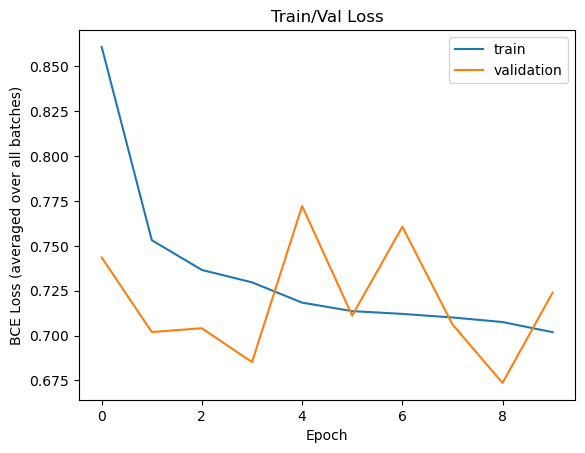

Accuracy: 0.8263579697239537
F1-Score: 0.3716433941997852
Precision: 0.4413265306122449
Recall: 0.3209647495361781
AUC: 0.722212


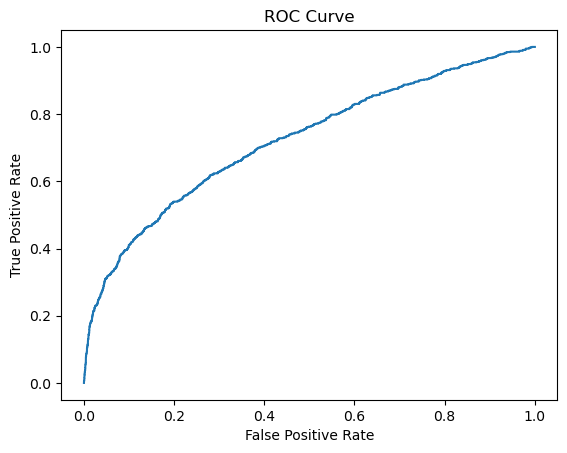

In [107]:
#Train model
model = NeuralNetwork() 
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
epochs = 10
train_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    total_train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    total_val_loss = test_loop(val_dataloader, model, loss_fn)
    train_loss.append(total_train_loss)
    val_loss.append(total_val_loss)

#Print loss plot
epoch_list = [i for i in range(epochs)]
plt.plot(epoch_list, train_loss, label='train')
plt.plot(epoch_list, val_loss, label='validation')
plt.xlabel("Epoch")
plt.ylabel("BCE Loss (averaged over all batches)")
plt.title("Train/Val Loss")
plt.legend()
plt.show()

#Print accuracy metrics on validation set
eval_loader = DataLoader(val_dataset, batch_size=len(val_dataset))
with torch.no_grad():
    preds = []
    labels = []
    for X, y in eval_loader:
        pred = model(X)
        preds = pred.flatten().tolist()
        labels = y.flatten().tolist()
    
    #print accuracy metrics
    mask = [0 if preds[i] < 0.5 else 1 for i in range(len(preds))]
    nn_metrics = predtest(mask, labels)

    #plot ROC curve
    fpr, tpr, thresholds = roc_curve(labels, preds)
    roc_auc = roc_auc_score(labels, preds)
    print("AUC: %f"%roc_auc)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

The number of layers, dimensions of layers, and regularization parameters were tuned; this is the best model achieved. The accuracy is similar to previous model architectures. The validation loss swings wildly, possibly indicating overfitting and/or too small a validation dataset.

Epoch 1
-------------------------------
Train loss for batch 0: 0.833930
Train loss for batch 100: 0.576984
Train loss for batch 200: 0.479390
Total train loss for epoch: 152.047931
Total val loss: 3151.794052
Epoch 2
-------------------------------
Train loss for batch 0: 0.447265
Train loss for batch 100: 0.447229
Train loss for batch 200: 0.438648
Total train loss for epoch: 130.993791
Total val loss: 2956.483720
Epoch 3
-------------------------------
Train loss for batch 0: 0.459959
Train loss for batch 100: 0.505608
Train loss for batch 200: 0.454941
Total train loss for epoch: 126.902812
Total val loss: 3134.162417
Epoch 4
-------------------------------
Train loss for batch 0: 0.505774
Train loss for batch 100: 0.340188
Train loss for batch 200: 0.441135
Total train loss for epoch: 124.446608
Total val loss: 2960.421475
Epoch 5
-------------------------------
Train loss for batch 0: 0.446222
Train loss for batch 100: 0.351303
Train loss for batch 200: 0.371499
Total train loss 

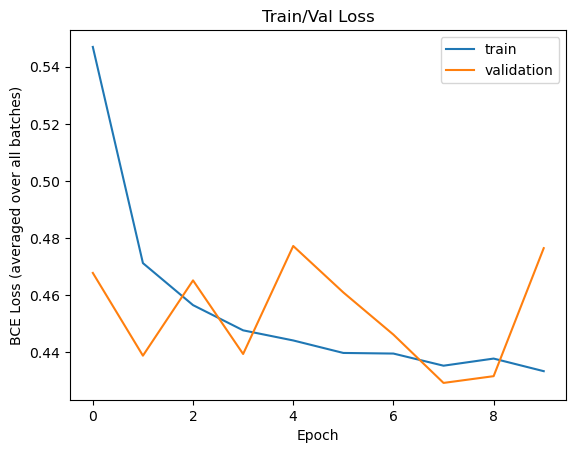

Accuracy: 0.8603443158207184
F1-Score: 0.37308461025982675
Precision: 0.35714285714285715
Recall: 0.3905160390516039
AUC: 0.713339


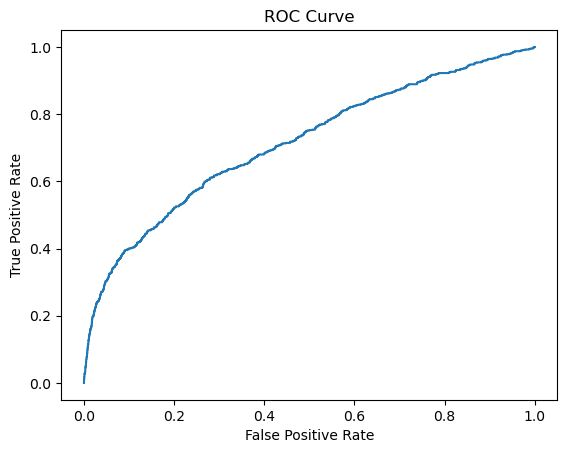

In [108]:
#Train on balanced dataset

# Create dataset and DataLoader
train_reduced_dataset = df2dataset(X_train_normed_smote_reduced, y_train_smote_reduced)
train_reduced_dataloader = DataLoader(train_reduced_dataset, batch_size=100, shuffle=True)

#Train model
model = NeuralNetwork() 
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.008)

epochs = 10
train_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    total_train_loss = train_loop(train_reduced_dataloader, model, loss_fn, optimizer)
    total_val_loss = test_loop(val_dataloader, model, loss_fn)
    train_loss.append(total_train_loss)
    val_loss.append(total_val_loss)

epoch_list = [i for i in range(epochs)]
plt.plot(epoch_list, train_loss, label='train')
plt.plot(epoch_list, val_loss, label='validation')
plt.xlabel("Epoch")
plt.ylabel("BCE Loss (averaged over all batches)")
plt.title("Train/Val Loss")
plt.legend()
plt.show()

#Print accuracy metrics on validation set
eval_loader = DataLoader(val_dataset, batch_size=len(val_dataset))
with torch.no_grad():
    preds = []
    labels = []
    for X, y in eval_loader:
        pred = model(X)
        preds = pred.flatten().tolist()
        labels = y.flatten().tolist()
    
    #print accuracy metrics
    mask = [0 if preds[i] < 0.5 else 1 for i in range(len(preds))]
    nn2_metrics = predtest(mask, labels)

    #plot ROC curve
    fpr, tpr, thresholds = roc_curve(labels, preds)
    roc_auc = roc_auc_score(labels, preds)
    print("AUC: %f"%roc_auc)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()


Performance is a little bit better on the balanced dataset.

In [109]:
#Append best-performing model metrics to metrics list
metrics.append(('nn2', nn2_metrics))

#### Wide and Cross Architecture
This architecture, also known as a Deep Cross Network, feeds an outer product of the categorical variables directly into the output layer, enabling the model to better capture the effects of combined categorical variables. It is typically used for product recommender systems, which is a similar problem case to the present (identifying customers most likely to subscribe to a product).

Epoch 1
-------------------------------
Train loss for batch 0: 0.677861
Train loss for batch 100: 0.428681
Train loss for batch 200: 0.453049
Train loss for batch 300: 0.348846
Train loss for batch 400: 0.388009
Total train loss for epoch: 180.453784
Total val loss: 2686.701137
Epoch 2
-------------------------------
Train loss for batch 0: 0.292401
Train loss for batch 100: 0.392740
Train loss for batch 200: 0.435122
Train loss for batch 300: 0.362701
Train loss for batch 400: 0.428858
Total train loss for epoch: 164.865008
Total val loss: 2224.772530
Epoch 3
-------------------------------
Train loss for batch 0: 0.399147
Train loss for batch 100: 0.386531
Train loss for batch 200: 0.528941
Train loss for batch 300: 0.305906
Train loss for batch 400: 0.348346
Total train loss for epoch: 162.104667
Total val loss: 2377.241219
Epoch 4
-------------------------------
Train loss for batch 0: 0.331635
Train loss for batch 100: 0.392747
Train loss for batch 200: 0.334636
Train loss for ba

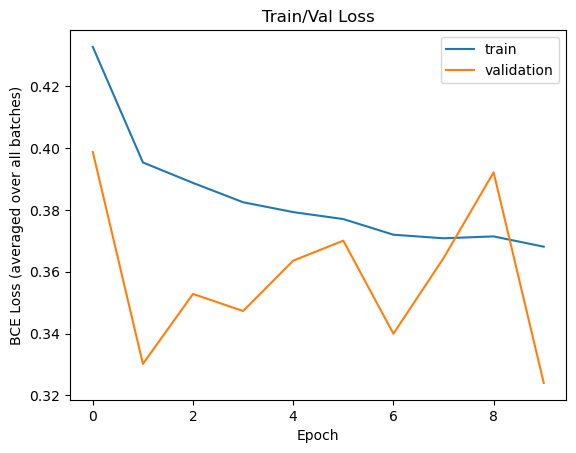

Accuracy: 0.8935886019590383
F1-Score: 0.2735562310030395
Precision: 0.17219387755102042
Recall: 0.6650246305418719
AUC: 0.726807


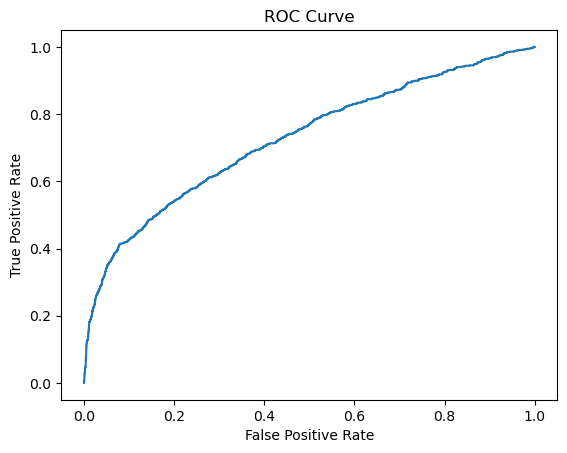

In [111]:
#Define model architecture
class WideandDeep(torch.nn.Module):
    def __init__(self, ncat, ncont, embeddim=5):
        super().__init__()
        self.embedding = torch.nn.Linear(ncat, embeddim)
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(ncont+embeddim, 64),
            torch.nn.ReLU(),
            #torch.nn.BatchNorm1d(64),
            #torch.nn.Dropout(p=0.2),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(64, 32),
        )
        self.output = torch.nn.Linear(32+ncat**2, 1)
            
    def forward(self, x_categorical, x_continuous):
        cross_product = torch.einsum('bi,bj->bij', x_categorical, x_categorical).flatten(start_dim=1)
        cat_embedded = self.embedding(x_categorical)
        linear_inputs = torch.cat((x_continuous, cat_embedded), 1)
        linear_outputs = self.linear_relu_stack(linear_inputs)
        combined_outputs = torch.cat((linear_outputs, cross_product), 1)
        out = self.output(combined_outputs)
        return out

#Function to load pandas df into torch dataset
class df2dataset_cross(Dataset):
    def __init__(self, Xin, yin, cat_cols, cont_cols):
        self.X_cat = torch.tensor(Xin[cat_cols].values, dtype=torch.float32)
        self.X_cont = torch.tensor(Xin[cont_cols].values, dtype=torch.float32)
        self.y = torch.tensor(yin.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X_cat)

    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_cont[idx], self.y[idx]

#Define training and testing loops
def wd_train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    epoch_train_loss = 0
    for batch, (X1, X2, y) in enumerate(dataloader):
        pred = model(X1, X2)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #Print loss every 100 batches
        if batch % 100 == 0:
            print("Train loss for batch %d: %f"%(batch, loss.item()))

        #add loss for batch to total loss for epoch
        epoch_train_loss += loss.item()

    print("Total train loss for epoch: %f"%epoch_train_loss)
    return(epoch_train_loss/len(dataloader)) #return average loss per batch

def wd_test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for X1, X2, y in dataloader:
            pred = model(X1, X2)
            test_loss += loss_fn(pred, y).item()
    print("Total val loss: %f"%test_loss)
    return(test_loss/len(dataloader))
    
#Define categorical and continuous columns
cat_cols = ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone']

cont_cols = ['age', 'education', 'balance', 'campaign', 'pdays', 'previous', 'day_of_month_rbf1',
       'day_of_month_rbf2', 'day_of_month_rbf3', 'day_of_month_rbf4',
       'month_rbf1', 'month_rbf2', 'month_rbf3', 'month_rbf4']

# Create dataset and DataLoader
train_dataset = df2dataset_cross(X_train_normed_smote, y_train_smote, cat_cols, cont_cols)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

val_dataset = df2dataset_cross(X_val_normed, y_val, cat_cols, cont_cols)
val_dataloader = DataLoader(val_dataset, batch_size=1)

#Train model
dcn_model = WideandDeep(len(cat_cols), len(cont_cols), embeddim=35) 
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(dcn_model.parameters(), lr=0.001, weight_decay=0.003)

epochs = 10
train_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    total_train_loss = wd_train_loop(train_dataloader, dcn_model, loss_fn, optimizer)
    total_val_loss = wd_test_loop(val_dataloader, dcn_model, loss_fn)
    train_loss.append(total_train_loss)
    val_loss.append(total_val_loss)

#Plot losses
epoch_list = [i for i in range(epochs)]
plt.plot(epoch_list, train_loss, label='train')
plt.plot(epoch_list, val_loss, label='validation')
plt.xlabel("Epoch")
plt.ylabel("BCE Loss (averaged over all batches)")
plt.title("Train/Val Loss")
plt.legend()
plt.show()

#Print accuracy on validation set
with torch.no_grad():
    preds = []
    actuals = []
    for X1, X2, y in val_dataloader:
        pred = dcn_model(X1, X2)
        preds.append(pred.item())
        actuals.append(y.item())

    #print accuracy metrics
    mask = [0 if preds[i] < 0.5 else 1 for i in range(len(preds))]
    dcn_metrics = predtest(mask, actuals)

    #plot ROC curve
    fpr, tpr, thresholds = roc_curve(actuals, preds)
    roc_auc = roc_auc_score(actuals, preds)
    print("AUC: %f"%roc_auc)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

Epoch 1
-------------------------------
Train loss for batch 0: 0.690499
Train loss for batch 100: 0.494581
Train loss for batch 200: 0.476011
Total train loss for epoch: 138.900743
Total val loss: 3146.258657
Epoch 2
-------------------------------
Train loss for batch 0: 0.424616
Train loss for batch 100: 0.426967
Train loss for batch 200: 0.437874
Total train loss for epoch: 122.911540
Total val loss: 3120.420573
Epoch 3
-------------------------------
Train loss for batch 0: 0.382152
Train loss for batch 100: 0.415162
Train loss for batch 200: 0.465428
Total train loss for epoch: 121.259917
Total val loss: 3218.726650
Epoch 4
-------------------------------
Train loss for batch 0: 0.438301
Train loss for batch 100: 0.539814
Train loss for batch 200: 0.380632
Total train loss for epoch: 119.872557
Total val loss: 3247.628999
Epoch 5
-------------------------------
Train loss for batch 0: 0.407192
Train loss for batch 100: 0.438911
Train loss for batch 200: 0.347665
Total train loss 

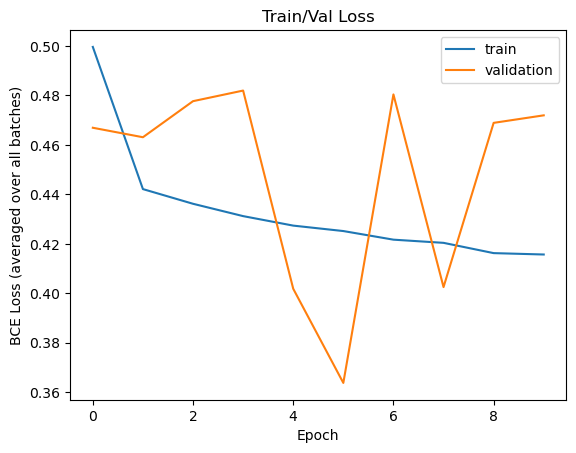

Accuracy: 0.8579697239536954
F1-Score: 0.37491835401698237
Precision: 0.36607142857142855
Recall: 0.38420348058902276
AUC: 0.724876


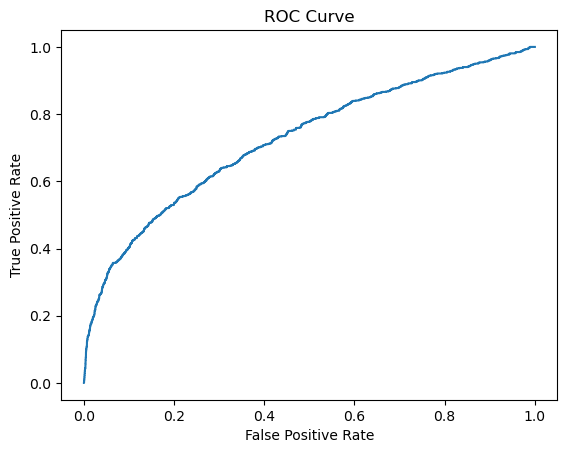

In [112]:
#Try Wide and Deep on balanced dataset

# Create dataset and DataLoader
train_dataset = df2dataset_cross(X_train_normed_smote_reduced, y_train_smote_reduced, cat_cols, cont_cols)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

val_dataset = df2dataset_cross(X_val_normed, y_val, cat_cols, cont_cols)
val_dataloader = DataLoader(val_dataset, batch_size=1)

#Train model
dcn2_model = WideandDeep(len(cat_cols), len(cont_cols), embeddim=35) 
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(dcn2_model.parameters(), lr=0.001, weight_decay=0.003)

epochs = 10
train_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    total_train_loss = wd_train_loop(train_dataloader, dcn2_model, loss_fn, optimizer)
    total_val_loss = wd_test_loop(val_dataloader, dcn2_model, loss_fn)
    train_loss.append(total_train_loss)
    val_loss.append(total_val_loss)

#Plot losses
epoch_list = [i for i in range(epochs)]
plt.plot(epoch_list, train_loss, label='train')
plt.plot(epoch_list, val_loss, label='validation')
plt.xlabel("Epoch")
plt.ylabel("BCE Loss (averaged over all batches)")
plt.title("Train/Val Loss")
plt.legend()
plt.show()

#Print accuracy on validation set
with torch.no_grad():
    preds = []
    actuals = []
    for X1, X2, y in val_dataloader:
        pred = dcn2_model(X1, X2)
        preds.append(pred.item())
        actuals.append(y.item())

    #print accuracy metrics
    mask = [0 if preds[i] < 0.5 else 1 for i in range(len(preds))]
    dcn2_metrics = predtest(mask, actuals)

    #plot ROC curve
    fpr, tpr, thresholds = roc_curve(actuals, preds)
    roc_auc = roc_auc_score(actuals, preds)
    print("AUC: %f"%roc_auc)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

In [113]:
#Append best-performing model metrics to metrics list
metrics.append(('dcn1', dcn_metrics))

### Metrics Comparison (Validation Dataset)

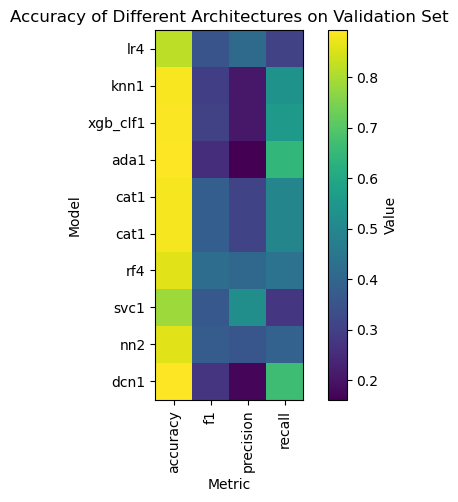

Recall values:
lr4 0.30451127819548873
knn1 0.5346534653465347
xgb_clf1 0.5544217687074829
ada1 0.6461538461538462
cat1 0.49390243902439024
cat1 0.49390243902439024
rf4 0.44005102040816324
svc1 0.2774018944519621
nn2 0.3905160390516039
dcn1 0.6650246305418719


In [ ]:
model_names = [metrics[i][0] for i in range(len(metrics))]
model_metrics = np.array([metrics[i][1] for i in range(len(metrics))])

#Plot heatmap of best metrics achieved for each architecture
plt.imshow(model_metrics)
plt.colorbar(label='Value')
plt.xlabel('Metric')
plt.ylabel('Model')
plt.yticks(ticks=[i for i in range(len(model_names))], labels=model_names)
plt.xticks(ticks=[i for i in range(4)], labels=['accuracy', 'f1', 'precision', 'recall'], rotation=90)
plt.title('Accuracy of Different Architectures on Validation Set')
plt.show()

#Print recall for each architecture
print("Recall values:")
for i in range(len(model_metrics)):
    print(model_names[i], model_metrics[i,3])

The architectures perform similarly. Recall above 0.5 is achieved by DCN (0.67), Adaboost (0.65), XGBoost (0.55), and KNN (0.53).

Before confirming the accuracy of these models on the test set, we should do any further hyperparameter tuning we want to do. We could, for instance, look at the emphasis each of these models places on the different features of the dataset. If there are features that are consistently not used by the models, we could delete those and re-train the models to see if they are better able to identify patterns in the dataset when they are not 'distracted' by these unhelpful features. We could also set up more exhaustive hyperparameter searches than the ones performed above.

### Performance on Test Set
Here we will test the top four models (DCN, Adaboost, XGBoost, and KNN) on the held-out test dataset.

In [116]:
print("DCN:")
test_dataset = df2dataset_cross(X_test_normed, y_test, cat_cols, cont_cols)
test_dataloader = DataLoader(test_dataset, batch_size=1)
with torch.no_grad():
    preds = []
    actuals = []
    for X1, X2, y in test_dataloader:
        pred = dcn_model(X1, X2)
        preds.append(pred.item())
        actuals.append(y.item())
    mask = [0 if preds[i] < 0.5 else 1 for i in range(len(preds))]
    dcn_test_metrics = predtest(mask, actuals)

print("\nAdaboost:")
ada1_test_preds = ada1.predict(X_test_normed)
ada_test_metrics = predtest(ada1_test_preds, y_test['label'])

print("\nXGBoost:")
xgb1_test_preds = xgb_clf1.predict(X_test_nonorm)
xgb_test_metrics = predtest(xgb1_test_preds, y_test['label'])

print("\nKNN:")
knn1_test_preds = knn1.predict(X_test_normed)
knn1_test_metrics = predtest(knn1_test_preds, y_test['label'])

DCN:
Accuracy: 0.8937527823119157
F1-Score: 0.2693877551020408
Precision: 0.171875
Recall: 0.6226415094339622

Adaboost:
Accuracy: 0.8922688826235347
F1-Score: 0.24688796680497926
Precision: 0.15494791666666666
Recall: 0.6071428571428571

XGBoost:
Accuracy: 0.8939011722807538
F1-Score: 0.33115060804490176
Precision: 0.23046875
Recall: 0.5880398671096345

KNN:
Accuracy: 0.8878171835583915
F1-Score: 0.26459143968871596
Precision: 0.17708333333333334
Recall: 0.5230769230769231


The models perform similarly on the test set as they had on the validation set, continuing to show recall above 0.5. These models are accurate enough that they could be useful tools in narrowing down the set of customers who should be contacted in the next marketing campaign. Analyzing the feature importances within the models could provide additional insight into the best customers to target. It is possible that combining these classifiers in an ensemble model would further improve accuracy.

### Utility Demonstration

Pretend the test set of 6,739 samples represents the bank's current membership. The bank wants to market a long-term deposit to their customers but can only afford to call 2,000 people. If they call 2,000 people at random:

In [129]:
random_customers = np.random.choice(y_test.values.ravel(), size=2000, replace=False)
print("Number of customers who will subscribe after phone contact: %d"%sum(random_customers))

Number of customers who will subscribe after phone contact: 232


Whereas, if they first identify the customers predicted by the DCN model to subscribe, and make sure that all those customers are included in the 2,000 contacted:

In [154]:
#Get model predictions
preds = []
actuals = []
with torch.no_grad():
    for X1, X2, y in test_dataloader:
        pred = dcn_model(X1, X2)
        preds.append(pred.item())
        actuals.append(y.item())

#Get indices of predicted positives
good_bet_ndx = np.where(np.array(preds) > 0.5)[0] 

#Pull actual values for predicted positives, delete those entries from actuals
sampled_customers = np.array(actuals)[good_bet_ndx]
actuals = np.delete(actuals, good_bet_ndx)

#Fill in sampled_customers with remaining random samples from actuals to get 2,000 samples
nneeded = 2000 - len(sampled_customers)
additional_samples = np.random.choice(actuals, size=nneeded, replace=False)
sampled_customers = np.hstack((sampled_customers, additional_samples))

print("Number of customers who will subscribe after phone contact: %d"%sum(sampled_customers))


Number of customers who will subscribe after phone contact: 312


In [156]:
n1 = sum(random_customers)
n2 = sum(sampled_customers)
improvement = (n2-n1)/n1
print("Targeting marketing calls using the DCN model improves the success rate of phone marketing by {:.0%}.".format(improvement))

Targeting marketing calls using the DCN model improves the success rate of phone marketing by 34%.


While the model is by no means perfect, it is useful in targeting the marketing effort in a case where not every customer can be called. 